This notebook focuses on exploring and engineering features from text data.

1. Generating Text Features: We will use the spaCy NLP analyzer to generate various discourse text features, including discourse length, sentence and word counts, and proportions of different word types. Visualizations and feature importance analysis using statistical tools and ML models, such as Random Forest, will help us identify the most influential features and their relationships with the target variable.

2. Generating Text Embeddings: We will apply different approaches to create vectorized representations of discourse and essay texts. These embeddings will be utilized in training ML models for classification tasks.

In [ ]:
!pip install patool sentence_transformers peft==0.12.0 compress-fasttext umap-learn

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import patoolib
import json
import pickle
import os

import re
import pandas as pd
import numpy as np

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import spacy

from gensim.models import FastText
import compress_fasttext

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, log_loss, silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from yellowbrick.cluster import KElbowVisualizer

from scipy.sparse import hstack
import scipy.stats as ss
from scipy.stats import kendalltau

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
from peft import AutoPeftModelForSequenceClassification

from functools import partial
from tqdm import tqdm
from tqdm import trange
import string
from collections import Counter

import umap

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
tqdm_iterator = partial(tqdm, position = 0, leave = True)

In [ ]:
mkdir data2022

In [ ]:
BASIC_PATH = '/content/gdrive/MyDrive/ML/projects/feedback-prize/'

In [ ]:
patoolib.extract_archive(BASIC_PATH+'data/feedback-prize-effectiveness.zip', outdir = '/content/data2022')

INFO patool: Extracting /content/gdrive/MyDrive/ML/projects/feedback-prize/data/feedback-prize-effectiveness.zip ...
INFO:patool:Extracting /content/gdrive/MyDrive/ML/projects/feedback-prize/data/feedback-prize-effectiveness.zip ...
INFO patool: running /usr/bin/7z x -o/content/data2022 -- /content/gdrive/MyDrive/ML/projects/feedback-prize/data/feedback-prize-effectiveness.zip
INFO:patool:running /usr/bin/7z x -o/content/data2022 -- /content/gdrive/MyDrive/ML/projects/feedback-prize/data/feedback-prize-effectiveness.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/gdrive/MyDrive/ML/projects/feedback-prize/data/feedback-prize-effectiveness.zip extracted to `/content/data2022'.
INFO:patool:... /content/gdrive/MyDrive/ML/projects/feedback-prize/data/feedback-prize-effectiveness.zip extracted to `/content/data2022'.


'/content/data2022'

In [ ]:
input_dir = '/content/data2022'

train_csv = os.path.join(input_dir, 'train.csv')

data_2022 = pd.read_csv(train_csv)

In [ ]:
data_2022.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


In [ ]:
data_2022.shape

(36765, 5)

In [ ]:
data_2022['discourse_id'].nunique()

36765

In [ ]:
data_2022['essay_id'].nunique()

4191

We will split the data by essay_id into three sets: the training set, used for training the first-level models; the holdout set, used for predicting with the first-level models and training a second-level model; and the test set, used for the final quality evaluation.

In [ ]:
train_holdout_ids, test_ids = train_test_split(data_2022['essay_id'].unique(), test_size = 0.2, random_state = 99)

In [ ]:
train_ids, holdout_ids = train_test_split(train_holdout_ids, test_size = 0.2, random_state = 78)

Save the splits using a dictionary for later access in other Jupyter notebooks.

In [ ]:
essay_ids_dict = {
    'train_ids': train_ids.tolist(),
    'holdout_ids': holdout_ids.tolist(),
    'test_ids': test_ids.tolist()
}

In [ ]:
# with open(BASIC_PATH+'data_splits.json', 'w') as file:
#     json.dump(essay_ids_dict, file)

In [ ]:
with open(BASIC_PATH+'data_splits.json', 'r') as file:
    loaded_essay_ids = json.load(file)

# Generating text features

In this section, we will generate discourse text features using a text analyzer like spaCy. Next, we will create visualizations and perform a feature importance analysis using statistical tools and ML models, such as Random Forest, to identify the most influential features and understand their relationship with the target variable.

We will generate a variety of features using the spaCy NLP analyzer, including discourse length, the number of sentences and words, proportions of long and short words, and proportions of different parts of speech.

In [ ]:
spacy_nlp = spacy.load('en_core_web_sm')

In [ ]:
def extract_features(text):

    doc = spacy_nlp(text)

    question_count = text.count('?')
    exclamation_count = text.count('!')

    # Initialize counters for different features
    num_long_words = 0
    num_short_words = 0
    pos_counter = Counter()

    for token in doc:
        # Count long and short words
        word_len = len(token.lemma_)
        if word_len > 6:
            num_long_words += 1
        elif word_len < 4:
            num_short_words += 1

        # Count POS tags
        pos_counter[token.pos_] += 1

    # Normalize POS counts by the number of words
    num_words = len([w for w in word_tokenize(text) if w not in string.punctuation])
    pos_features = {
        'discourse_verb_count': pos_counter['VERB'] / num_words,
        'discourse_noun_count': pos_counter['NOUN'] / num_words,
        'discourse_adj_count': pos_counter['ADJ'] / num_words,
        'discourse_numeral_count': pos_counter['NUM'] / num_words,
        'discourse_pnoun_count': pos_counter['PROPN'] / num_words,
        'discourse_conj_count': pos_counter['SCONJ'] / num_words
    }

    return {
        'discourse_len': len(text),
        'discourse_num_sent': len(sent_tokenize(text)),
        'discourse_num_words': num_words,
        'discourse_question_count': question_count,
        'discourse_exclamation_count': exclamation_count,
        'discourse_num_long_words': num_long_words / num_words,
        'discourse_num_short_words': num_short_words / num_words,
        **pos_features
    }

In [ ]:
features = data_2022['discourse_text'].apply(extract_features)

In [ ]:
features_df = pd.DataFrame(list(features))
features_df['discourse_effectiveness'] = data_2022['discourse_effectiveness'].replace({'Ineffective': 0,
                                                                                       'Adequate': 1,
                                                                                       'Effective': 2})

Next, we will use Kendall's Tau coefficient to assess the correlation between the continuous features and our ordinal target variable. This will help identify which features might be of interest.

In [ ]:
def kendall_corr(feature):
    tau, p_value = kendalltau(features_df[feature], features_df['discourse_effectiveness'])
    return tau, p_value

In [ ]:
kendall_corrs = {}
p_values = {}

# Loop through each feature (excluding 'discourse_effectiveness')
for feature in features_df.columns:
    if feature != 'discourse_effectiveness':
        tau, p_value = kendall_corr(feature)
        kendall_corrs[feature] = tau
        p_values[feature] = p_value

kendall_corrs_df = pd.DataFrame.from_dict(kendall_corrs, orient='index', columns=['Kendall Tau Correlation'])
p_values_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['p-value'])
combined_df = kendall_corrs_df.join(p_values_df)

In [ ]:
def format_heatmap(row):
    return f'{row["Kendall Tau Correlation"]:.4f}\n(p={row["p-value"]:.3f})'

In [ ]:
heatmap_text = combined_df.apply(format_heatmap, axis=1).to_frame(name='Text')

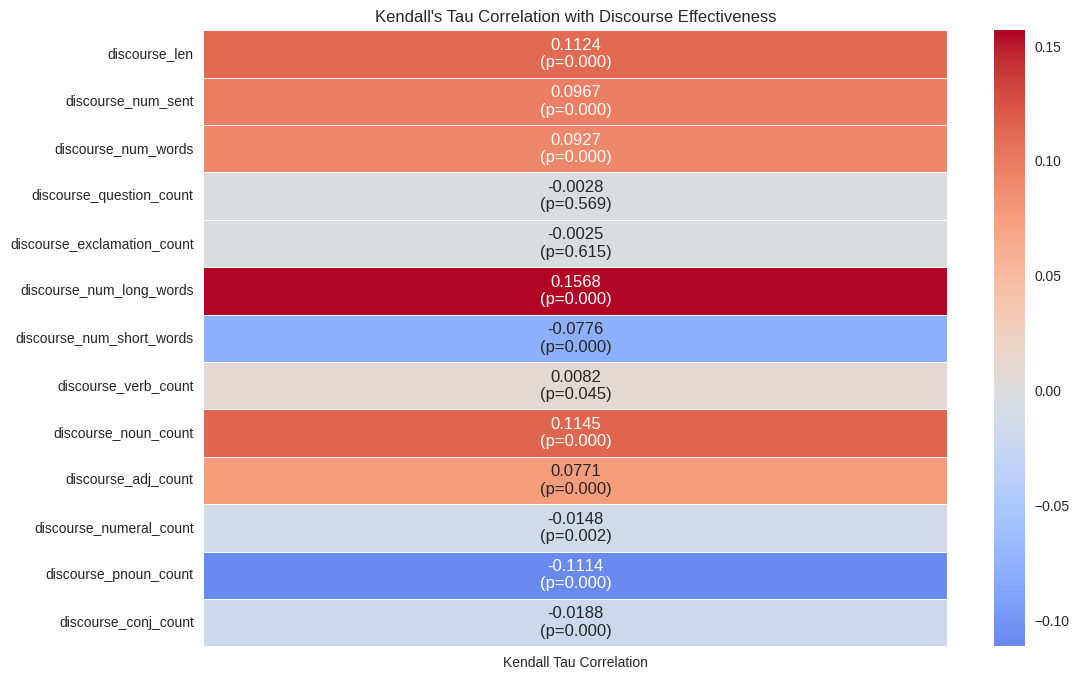

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(combined_df.drop('p-value', axis = 1), annot=heatmap_text, fmt='', cmap='coolwarm', center=0, linewidths=.5)
plt.title("Kendall's Tau Correlation with Discourse Effectiveness")
plt.show()

Interestingly, longer texts and sentences, as well as the use of longer words, more nouns, and adjectives, are associated with higher discourse scores. Conversely, shorter words and the frequent use of personal pronouns are associated with lower scores. This might be because shorter words and personal pronouns often reflect a more personal perspective, rather than demonstrating the student's ability and willingness to reference sources and use others' opinions to support their own stance.

We will also apply an ML model, such as Random Forest, which has a built-in feature selection mechanism, to see if the results are consistent with our previous findings.

In [ ]:
X = features_df.drop(columns='discourse_effectiveness')
y = features_df['discourse_effectiveness']

rf = RandomForestClassifier(random_state = 88)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [6, 8, 10],
    'min_samples_split': [2, 5, 7, 10],
    'max_features': ['sqrt', 'log2']
}

skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 88)

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring = 'f1_macro', cv = skf)
grid_search.fit(X, y)

best_score = grid_search.best_score_
best_rf = grid_search.best_estimator_
importances = best_rf.feature_importances_

In [ ]:
print(f"Best Score from Grid Search: {best_score:.4f}")

Best Score from Grid Search: 0.4209


<ipython-input-163-9f57227f6dca>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'Importance', y = 'Feature', data = feature_importances_df, palette = 'viridis')


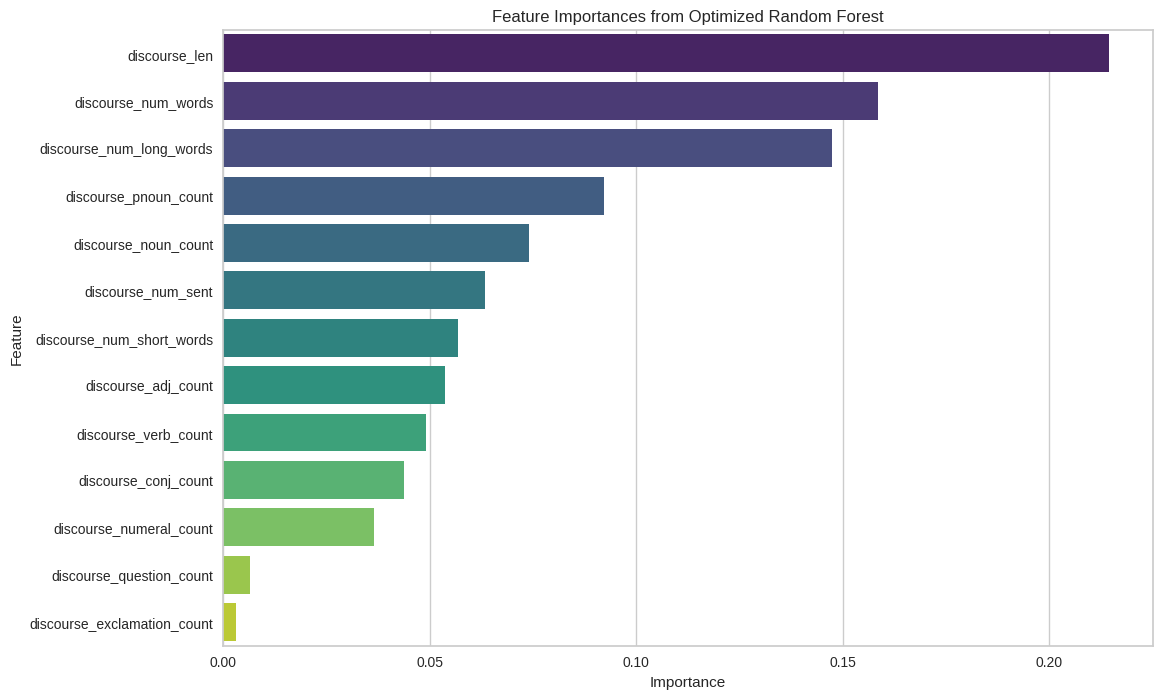

In [ ]:
# Create a DataFrame of features and their importances
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (12, 8))
sns.barplot(x = 'Importance', y = 'Feature', data = feature_importances_df, palette = 'viridis')
plt.title('Feature Importances from Optimized Random Forest')
plt.show()

Use Spearman's rank correlation matrix to identify multicollinear features. Spearman's rank correlation is used because the features are continuous and their relationships might be non-linear.

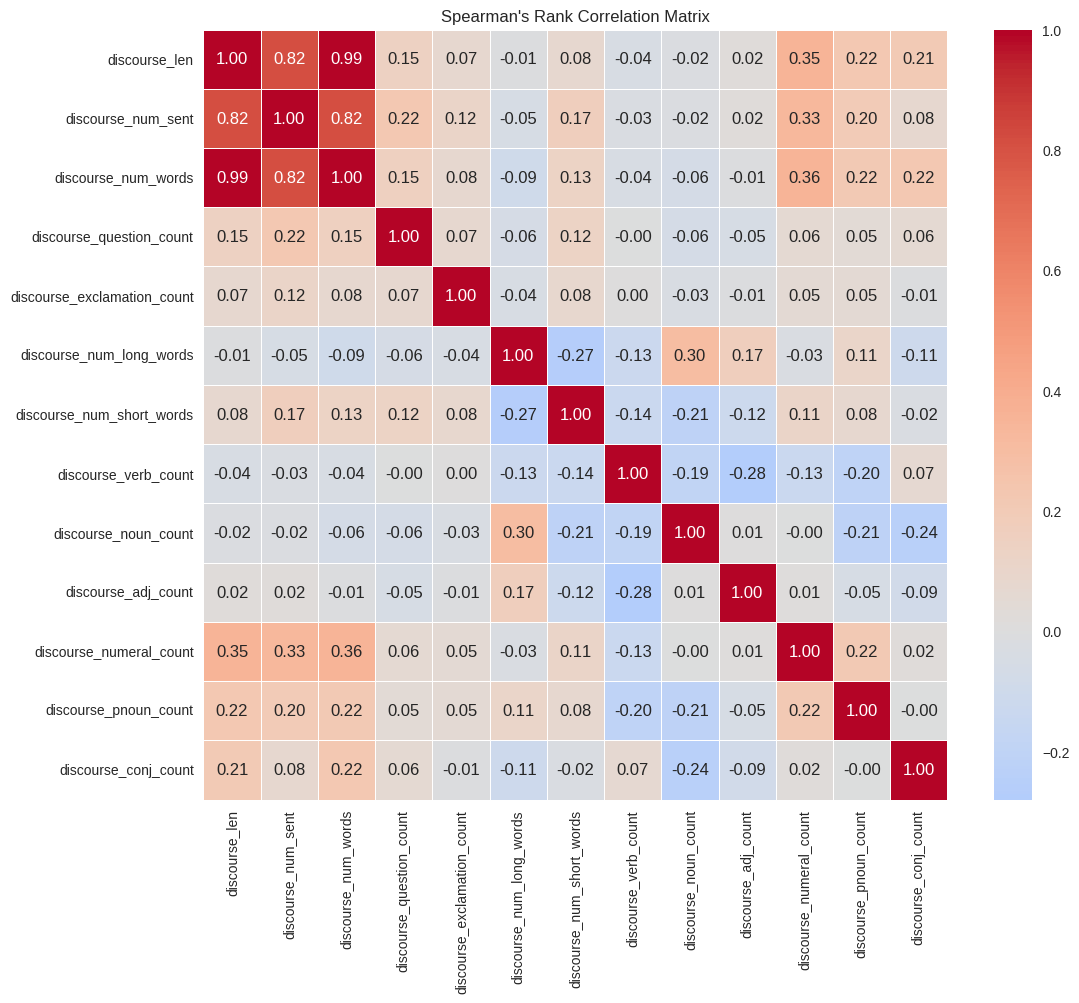

In [ ]:
spearman_corr_matrix = features_df.drop('discourse_effectiveness', axis = 1).corr(method = 'spearman')

plt.figure(figsize=(12, 10))
sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=.5, fmt='.2f')
plt.title("Spearman's Rank Correlation Matrix")
plt.show()

We can see that the results from Kendall's Tau are consistent with those from Random Forest. The features that show the highest correlation with the target variable are discourse length, the number of words and sentences, proportions of long and short words, and proportions of nouns, pronouns, and adjectives. The remaining features can be safely dropped as they provide little meaningful information for predicting the target.

Additionally, the Spearman rank correlation has revealed high collinearity between discourse length, the number of sentences, and the number of words. Given that discourse length has the highest importance, we will retain it.

Thus, the final set of text features to be used by our predictive models is as follows:

- discourse_len
- discourse_num_long_words
- discourse_num_short_words
- discourse_noun_count
- discourse_adj_count
- discourse_pnoun_count

# Generating text embeddings

In this section, we will apply various approaches to obtain vectorized representations of discourse and essay texts. These representations will be used in training ML models for the classification task at hand.

## Get discourse embeddings using trained ROBERTA

In this section, we will use a ROBERTA model trained on 2021 data to predict discourse types. Although the task we are addressing here is different, the model will still produce high-quality embeddings of raw discourse texts. These embeddings can be used as features for other classification models, such as LSTM and XGBoost.

First, let's perform a sanity check on a single sample to ensure the model is working as expected.

In [ ]:
TRAINED_TOKENIZER = 'roberta-base-tokenizer'
PEFT_MODEL = 'roberta-base-peft'

PEFT_MODEL_PATH = BASIC_PATH+PEFT_MODEL
TOKENIZER_PATH = BASIC_PATH+TRAINED_TOKENIZER

In [ ]:
data_2021 = pd.read_csv(BASIC_PATH+'data/train_2021.csv')

In [ ]:
class_names = list(set(data_2021['discourse_type']))
class_names.sort()

label_to_id = {label: i for i, label in enumerate(class_names)}
id_to_label = {i: label for i, label in enumerate(class_names)}

In [ ]:
roberta_inference_model = AutoPeftModelForSequenceClassification.from_pretrained(PEFT_MODEL_PATH, id2label = id_to_label, label2id = label_to_id)
roberta_tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
roberta_inference_model.to(device)

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.2, inplace=False)
                    )
                    (lora_A): ModuleD

In [ ]:
sample_text = data_2022.iloc[0, 2]

In [ ]:
inputs = roberta_tokenizer(sample_text, max_length = 200, truncation = True, padding = True, return_tensors = "pt")

In [ ]:
inputs.to(device)

{'input_ids': tensor([[    0, 30086,     6,   939,   437, 12370,     6,   939,   437,   164,
             7,    28,  2410,    59,   141,    42,   652,    15,  6507,    16,
            10,  1632,  1212,  3899,    50,   114,    89,    16,   301,    15,
          6507,    14,   156,    24,     4,    20,   527,    16,    59,   141,
          6109,   362,    10,  2170,     9,  6507,     8,    10,   652,    21,
           450,    15,     5,  5518,     4,  6109,   630,    75,   216,   114,
             5,  1212,  3899,    21,  1412,    30,   301,    15,  6507,     6,
            50,   114,    24,    16,    95,    10,  1632,  1212,  3899,     4,
          1437,     2]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='c

In [ ]:
roberta_inference_model.eval()
with torch.no_grad():
  output = roberta_inference_model(**inputs)

In [ ]:
id_to_label[output.logits.argmax(dim=-1).item()]

'Lead'

In [ ]:
roberta_inference_model.eval()
with torch.no_grad():
  roberta_output = roberta_inference_model.roberta(**inputs)

In [ ]:
# This is the recommended approach for obtaining the average of all token embeddings in a sequence.

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

Note that if the tokenizer's padding parameter is set to True, and we feed a single sequence into the tokenizer, it will have no padding. Therefore, it doesn't matter if we use the mean_pooling function or a simple torch.mean to get the average embedding. However, when performing batch processing, sequences in the batch will be padded to the maximum length of the sequence in that batch. In this case, when obtaining the average, you must be careful not to use the naive mean approach, or you risk obtaining diluted embeddings.

In [ ]:
sample_embedding = mean_pooling(roberta_output, inputs['attention_mask'])
sample_embedding_2 = torch.mean(roberta_output.last_hidden_state, dim = 1)

In [ ]:
sample_embedding.size()

torch.Size([1, 768])

In [ ]:
sample_embedding_2.size()

torch.Size([1, 768])

In [ ]:
np.allclose(sample_embedding[0].cpu().numpy(), sample_embedding_2[0].cpu().numpy())

True

In [ ]:
def get_sentence_embeddings(batch_sentences):
    inputs = roberta_tokenizer(batch_sentences, max_length = 200, truncation = True, padding = True, return_tensors = "pt")
    roberta_inference_model.eval()
    with torch.no_grad():
        inputs.to(device)
        outputs = roberta_inference_model.roberta(**inputs)
    sentence_embeddings = mean_pooling(outputs, inputs['attention_mask'])
    #sentence_embeddings = torch.mean(outputs.last_hidden_state, dim = 1) # see above why this approach is not recommended
    return sentence_embeddings.cpu().numpy()

In [ ]:
discourse_ids = data_2022['discourse_id'].tolist()
discourse_sentences = data_2022['discourse_text'].tolist()

batch_size = 32
discourse_embeddings = []

for i in tqdm(range(0, len(discourse_sentences), batch_size)):
    batch_sentences = discourse_sentences[i:i + batch_size]
    batch_embeddings = get_sentence_embeddings(batch_sentences)
    discourse_embeddings.extend(batch_embeddings)

discourse_embeddings = np.array(discourse_embeddings)

100%|██████████| 1149/1149 [05:51<00:00,  3.27it/s]


In [ ]:
discourse_embeddings.shape

(36765, 768)

In [ ]:
#np.savez(BASIC_PATH+'embeddings/2022_discourse_embeddings.npz', discourse_ids = discourse_ids, discourse_embeddings = discourse_embeddings)

In [ ]:
data = np.load(BASIC_PATH+'embeddings/2022_discourse_embeddings.npz')

In [ ]:
loaded_discourse_ids = data['discourse_ids']
loaded_discourse_embeddings = data['discourse_embeddings']

In [ ]:
print(loaded_discourse_ids.shape)
print(loaded_discourse_embeddings.shape)

(36765,)
(36765, 768)


Let's perform a quick sanity check to ensure that the embedding we obtained for the first sample matches the first one in our loaded embeddings.

In [ ]:
np.allclose(loaded_discourse_embeddings[0], sample_embedding[0].cpu().numpy(), atol = 1e-5)

True

In [ ]:
cosine_similarity(loaded_discourse_embeddings[0].reshape(1, -1), sample_embedding[0].cpu().numpy().reshape(1, -1))

array([[0.99999994]], dtype=float32)

In [ ]:
df_discourse_embeddings = pd.DataFrame(loaded_discourse_embeddings)
df_discourse_embeddings.columns = [f'disc_emb_dim_{i+1}' for i in range(df_discourse_embeddings.shape[1])]
df_discourse_embeddings['discourse_id'] = loaded_discourse_ids
df_discourse_embeddings = df_discourse_embeddings[['discourse_id'] + [col for col in df_discourse_embeddings.columns if col != 'discourse_id']]

In [ ]:
df_discourse_embeddings.head()

,discourse_id,disc_emb_dim_1,disc_emb_dim_2,disc_emb_dim_3,disc_emb_dim_4,disc_emb_dim_5,disc_emb_dim_6,disc_emb_dim_7,disc_emb_dim_8,disc_emb_dim_9,...,disc_emb_dim_759,disc_emb_dim_760,disc_emb_dim_761,disc_emb_dim_762,disc_emb_dim_763,disc_emb_dim_764,disc_emb_dim_765,disc_emb_dim_766,disc_emb_dim_767,disc_emb_dim_768
0,0013cc385424,-0.074544,-0.251746,0.039989,-0.269454,1.274046,0.636828,0.285024,1.007192,0.069854,...,-0.028507,-0.030316,-0.269066,-0.164834,-0.058057,0.309342,0.607125,-0.614451,0.164037,-0.042976
1,9704a709b505,-0.138114,0.159553,0.071121,0.040252,1.012260,0.953447,0.269533,0.885836,0.498467,...,-0.753420,-0.740413,-0.157875,-0.103554,0.553908,0.303424,0.814504,-0.287636,-0.174267,-0.733787
2,c22adee811b6,-0.405241,-0.825316,-0.022330,-0.400907,1.285600,0.435820,0.202860,0.898636,-0.563716,...,-0.622115,-0.528273,-1.179233,-0.565132,0.070622,0.366844,0.558589,-0.289884,-0.228211,-0.670518
3,a10d361e54e4,-0.182680,-0.113140,-0.131830,0.145519,0.970769,0.530573,0.057293,0.502485,0.942897,...,-0.297033,-0.423347,-0.280275,-0.214234,0.504504,-0.005146,0.118951,-0.036993,-0.369095,-0.447838
4,db3e453ec4e2,-0.699138,-0.639889,-0.198978,-0.565757,1.386011,0.467251,0.718829,0.862455,-0.483619,...,-0.073979,0.047259,-0.754080,-0.312474,0.095637,0.791220,-0.240540,-0.053344,-0.898949,-0.302612


## Get essay embeddings using pre-trained BERT sentence model

In [ ]:
essay_ids = data_2022['essay_id'].unique()

In [ ]:
def clean_text(text):
    # Replace escaped apostrophes with actual apostrophes
    text = re.sub(r"\\'", "'", text)
    # Replace escaped newline characters with actual newlines
    text = re.sub(r"\\n", "\n", text)
    # Remove other unnecessary backslashes
    text = re.sub(r"\\", "", text)
    # Replace newline characters with spaces
    text = text.replace("\n", " ")
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Strip leading/trailing whitespace
    text = text.strip()
    return text

In [ ]:
essay_texts = []

for id in essay_ids:
    essay_path = os.path.join('/content/data2022/train', f"{id}.txt")
    with open(essay_path, 'r', encoding='utf-8') as file:
        essay = file.read()
        cleaned_essay = clean_text(essay)
        essay_texts.append(cleaned_essay)

Now, we will use a pre-trained BERT sentence transformer to obtain essay embeddings. For each essay, we will tokenize it into a list of sentences, apply the pre-trained model to get the embedding for each sentence, and then compute the mean of all sentence embeddings. We will save these embeddings as a NumPy array, along with the corresponding essay IDs, for further use, just as we did with the discourse embeddings above.

In [ ]:
sentence_tranformer = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
essays_tokenized = [sent_tokenize(essay) for essay in essay_texts]

In [ ]:
# Function to compute the mean embedding of a list of sentences
def get_mean_embedding(sentences):
    if len(sentences) > 1:
        embeddings = sentence_tranformer.encode(sentences, show_progress_bar=False)
        mean_embedding = np.mean(embeddings, axis = 0)
    else:
        mean_embedding = sentence_tranformer.encode(sentences[0])
    return mean_embedding

In [ ]:
essay_embeddings = [get_mean_embedding(essay) for essay in tqdm_iterator(essays_tokenized)]

100%|██████████| 4191/4191 [37:19<00:00,  1.87it/s]


In [ ]:
essay_embeddings = np.asarray(essay_embeddings)

In [ ]:
#np.savez(BASIC_PATH+'embeddings/2022_essay_embeddings.npz', essay_ids = essay_ids, essay_embeddings = essay_embeddings)

In [ ]:
data = np.load(BASIC_PATH+'embeddings/2022_essay_embeddings.npz', allow_pickle=True)

In [ ]:
loaded_essay_ids = data['essay_ids']
loaded_essay_embeddings = data['essay_embeddings']

In [ ]:
print(loaded_essay_ids.shape)
print(loaded_essay_embeddings.shape)

(4191,)
(4191, 384)


In [ ]:
df_essay_embeddings = pd.DataFrame(loaded_essay_embeddings)
df_essay_embeddings.columns = [f'essay_emb_dim_{i+1}' for i in range(df_essay_embeddings.shape[1])]
df_essay_embeddings['essay_id'] = loaded_essay_ids
df_essay_embeddings = df_essay_embeddings[['essay_id'] + [col for col in df_essay_embeddings.columns if col != 'essay_id']]

In [ ]:
df_essay_embeddings.head()

,essay_id,essay_emb_dim_1,essay_emb_dim_2,essay_emb_dim_3,essay_emb_dim_4,essay_emb_dim_5,essay_emb_dim_6,essay_emb_dim_7,essay_emb_dim_8,essay_emb_dim_9,...,essay_emb_dim_375,essay_emb_dim_376,essay_emb_dim_377,essay_emb_dim_378,essay_emb_dim_379,essay_emb_dim_380,essay_emb_dim_381,essay_emb_dim_382,essay_emb_dim_383,essay_emb_dim_384
0,007ACE74B050,0.011675,0.008128,0.021032,-0.001148,0.030272,-0.073278,-0.022646,-0.027777,-0.012271,...,0.064735,-0.012869,0.016128,0.006209,0.004061,0.053964,-0.010016,0.010343,-0.010910,0.041069
1,00944C693682,0.053501,0.041472,0.072293,0.034796,0.040148,0.019340,0.012896,0.007692,-0.033432,...,0.033510,-0.016763,-0.012068,0.009766,-0.010827,-0.014054,0.026037,0.022251,0.010107,0.031330
2,00BD97EA4041,-0.014482,0.027644,0.024738,-0.021590,0.016479,-0.016790,0.017035,-0.015605,0.026015,...,0.030305,0.001151,-0.000607,0.019716,-0.033894,0.031733,0.056291,0.031456,-0.002304,-0.003539
3,00C6E82FE5BA,-0.062857,-0.005400,0.014592,-0.030059,0.066248,0.001064,0.061247,0.008068,0.031039,...,0.057417,-0.015536,0.024880,0.026257,-0.005454,0.054577,0.048538,0.016117,-0.023856,0.010883
4,013B9AA6B9DB,-0.016238,0.040474,0.020973,0.024325,0.057331,-0.063316,-0.012638,-0.022030,0.003975,...,0.011134,-0.034961,0.026750,-0.020137,-0.024651,0.038006,0.034120,0.005487,-0.011730,0.055912


A quick way to check if the resulting essay embeddings are any good.

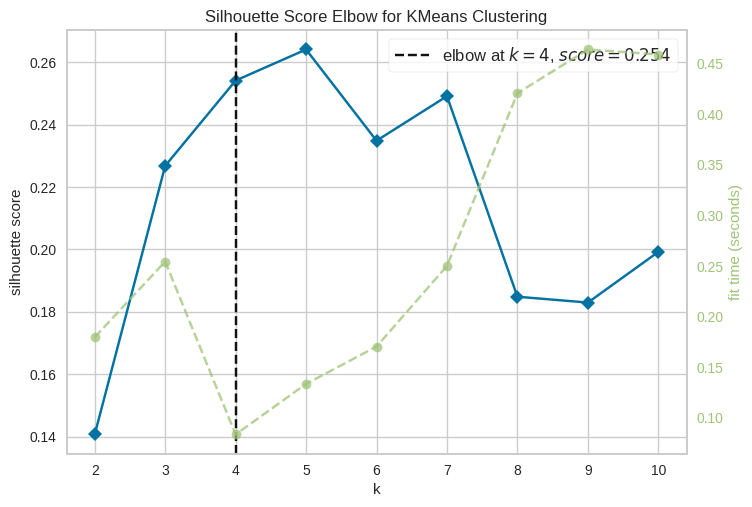

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [ ]:
model = KMeans(n_init = 'auto', init = 'k-means++', random_state = 88)
visualizer = KElbowVisualizer(model, k = (2, 11), metric = 'silhouette', timings = True)
visualizer.fit(df_essay_embeddings.iloc[:, 1:].values)
visualizer.show()

In [ ]:
tsne = TSNE(n_components = 2, random_state = 88)
X_tsne = tsne.fit_transform(df_essay_embeddings.iloc[:, 1:].values)

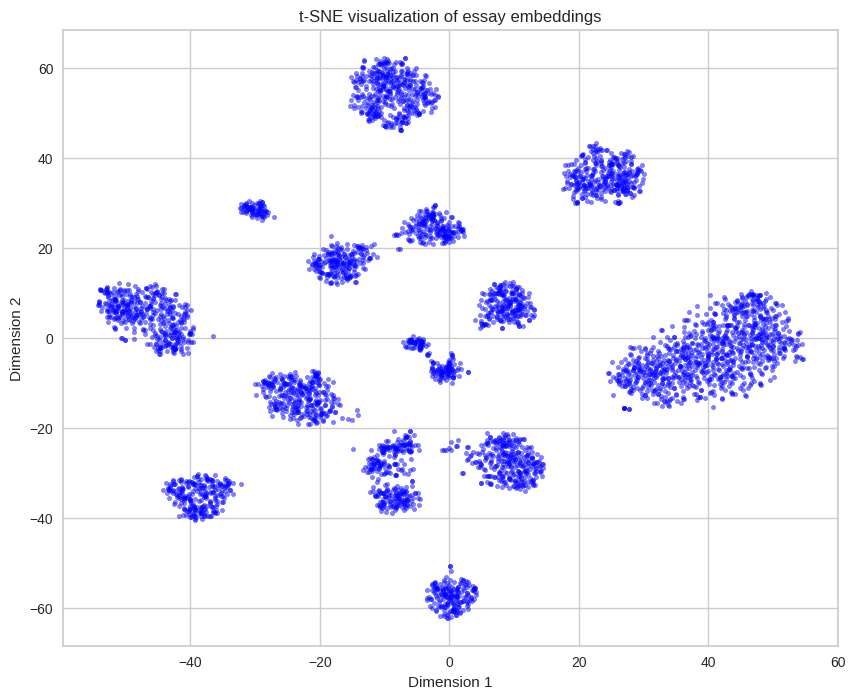

In [ ]:
# Create a DataFrame for plotting
df_tsne = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
df_tsne['essay_id'] = df_essay_embeddings['essay_id']

plt.figure(figsize = (10, 8))
plt.scatter(df_tsne['Dim1'], df_tsne['Dim2'], c = 'blue', s = 10, alpha = 0.5)
plt.title('t-SNE visualization of essay embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

## Get discourse embeddings using a fasttext model

Let's compare the quality of a custom low-dimension FastText model trained on our data against that of a pretrained FastText model.

Credit:

- original model: https://fasttext.cc/docs/en/crawl-vectors.html
- compessed fasttext format: https://github.com/avidale/compress-fasttext
- compressed models: https://zenodo.org/records/4905385

In [ ]:
train_data = data_2022[data_2022['essay_id'].isin(loaded_essay_ids['train_ids'])]

In [ ]:
train_data.reset_index(drop = True, inplace = True)

In [ ]:
def preprocess_text(text):

    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]

    return tokens

# Function to get the embedding for a single sentence
def get_sentence_embedding(sentence, model):
    tokens = preprocess_text(sentence)
    embeddings = [model[word] for word in tokens if word in model]
    if embeddings:
        return np.mean(embeddings, axis = 0)
    else:
        return np.zeros(model.vector_size)

# Function to get the embedding for an entire text (multiple sentences)
def get_text_embedding(text, model):

    sentences = nltk.sent_tokenize(text)
    sentence_embeddings = [get_sentence_embedding(sentence, model) for sentence in sentences]
    text_embedding = np.mean(sentence_embeddings, axis = 0)
    return text_embedding

def get_mean_embedding_custom(tokens, model):

    embeddings = []

    for token in tokens:
        try:
            embedding = model.wv[token]
            embeddings.append(embedding)
        except KeyError:
            print(f"Warning: Token '{token}' not in vocabulary.")
            embeddings.append(np.zeros(model.vector_size))

    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

Load and apply a compressed pretrained fasttext model.

In [ ]:
pretrained_ft_model = compress_fasttext.models.CompressedFastTextKeyedVectors.load(BASIC_PATH+'ft-model/cc.en.300.compressed.bin')

In [ ]:
# sanity check
pretrained_ft_model.most_similar('Python')

[('PHP', 0.5252903479827643),
 ('.NET', 0.5027453127530029),
 ('Java', 0.489713161637833),
 ('syntax', 0.48009634662463707),
 ('Programming', 0.47753022364138975),
 ('MySQL', 0.4607097434065481),
 ('API', 0.4419124174767262),
 ('programming', 0.435960081807873),
 ('GUI', 0.43157509560182317),
 ('scripts', 0.42872353623161275)]

In [ ]:
train_data['pretrained_fasttext_embedding'] = train_data['discourse_text'].apply(lambda x: get_text_embedding(x, pretrained_ft_model))

<ipython-input-41-d7c88266a532>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['pretrained_fasttext_embedding'] = train_data['discourse_text'].apply(lambda x: get_text_embedding(x, pretrained_ft_model))


Clean the discourse texts, train and apply a custom fasttext model.

In [ ]:
train_data['clean_discourse'] = train_data['discourse_text'].progress_apply(preprocess_text)

100%|██████████| 23462/23462 [00:20<00:00, 1135.02it/s]
<ipython-input-81-6290c42f41d8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['clean_discourse'] = train_data['discourse_text'].progress_apply(preprocess_text)


In [ ]:
custom_ft_model = FastText(vector_size = 64, window = 3, min_count = 3)
custom_ft_model.build_vocab(corpus_iterable = train_data['clean_discourse'])

In [ ]:
vocab = custom_ft_model.wv
vocabulary_words = list(vocab.key_to_index.keys())

In [ ]:
len(vocabulary_words)

8088

In [ ]:
vocabulary_words[:10]

['students',
 'would',
 'people',
 'school',
 'electoral',
 'vote',
 'college',
 'like',
 'could',
 'one']

In [ ]:
custom_ft_model.train(corpus_iterable = train_data['clean_discourse'], total_examples = len(train_data), epochs = 10)

(4512170, 5205510)

In [ ]:
custom_ft_model.wv.most_similar(positive = ['students'])

[('studens', 0.9256487488746643),
 ('studen', 0.9056612849235535),
 ('student', 0.8946565389633179),
 ('sudents', 0.8884574770927429),
 ('studenst', 0.8640879392623901),
 ('studentbased', 0.8614676594734192),
 ('studentdesign', 0.850062906742096),
 ('studentsummerpacketdesigners', 0.8472457528114319),
 ('stundents', 0.8238999247550964),
 ('student_name', 0.8180554509162903)]

In [ ]:
train_data['custom_fasttext_embedding'] = train_data['clean_discourse'].progress_apply(lambda x: get_mean_embedding_custom(x, custom_ft_model))

100%|██████████| 23462/23462 [00:08<00:00, 2818.21it/s]
<ipython-input-99-7d33bfb71a20>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['custom_fasttext_embedding'] = train_data['clean_discourse'].progress_apply(lambda x: get_mean_embedding_custom(x, custom_ft_model))


Compare the two models.

In [ ]:
pretrained_fasttext_embeddings = np.vstack(train_data['pretrained_fasttext_embedding'].values)
custom_fasttext_embeddings = np.vstack(train_data['custom_fasttext_embedding'].values)

In [ ]:
n_clusters = train_data['discourse_effectiveness'].nunique()

kmeans_pretrained = KMeans(n_init = 10, n_clusters = n_clusters, random_state = 97)
kmeans_pretrained.fit(pretrained_fasttext_embeddings)

kmeans_custom = KMeans(n_init = 10, n_clusters = n_clusters, random_state = 97)
kmeans_custom.fit(custom_fasttext_embeddings)

KMeans(n_clusters=3, n_init=10, random_state=97)

In [ ]:
silhouette_pretrained = silhouette_score(pretrained_fasttext_embeddings, kmeans_pretrained.labels_)
davies_bouldin_pretrained = davies_bouldin_score(pretrained_fasttext_embeddings, kmeans_pretrained.labels_)
calinski_harabasz_pretrained = calinski_harabasz_score(pretrained_fasttext_embeddings, kmeans_pretrained.labels_)

silhouette_custom = silhouette_score(custom_fasttext_embeddings, kmeans_custom.labels_)
davies_bouldin_custom = davies_bouldin_score(custom_fasttext_embeddings, kmeans_custom.labels_)
calinski_harabasz_custom = calinski_harabasz_score(custom_fasttext_embeddings, kmeans_custom.labels_)

In [ ]:
print(f'Silhouette Score (Pre-trained): {silhouette_pretrained}')
print(f'Davies-Bouldin Index (Pre-trained): {davies_bouldin_pretrained}')
print(f'Calinski-Harabasz Index (Pre-trained): {calinski_harabasz_pretrained}')
print(f'Silhouette Score (Custom): {silhouette_custom}')
print(f'Davies-Bouldin Index (Custom): {davies_bouldin_custom}')
print(f'Calinski-Harabasz Index (Custom): {calinski_harabasz_custom}')

Silhouette Score (Pre-trained): 0.07182043723094296
Davies-Bouldin Index (Pre-trained): 3.1449283474087717
Calinski-Harabasz Index (Pre-trained): 1392.8420775364825
Silhouette Score (Custom): 0.18507119341244183
Davies-Bouldin Index (Custom): 2.015270258062374
Calinski-Harabasz Index (Custom): 4354.461772978738


In [ ]:
tsne = TSNE(n_components = 2, random_state = 88)
X_tsne = tsne.fit_transform(custom_fasttext_embeddings)

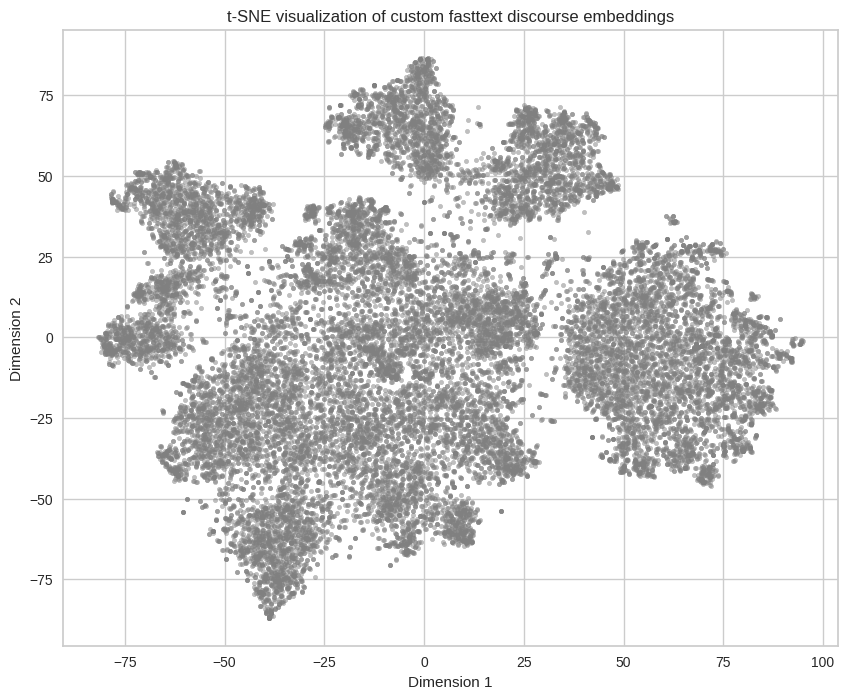

In [ ]:
df_tsne = pd.DataFrame(X_tsne, columns = ['Dim1', 'Dim2'])

plt.figure(figsize = (10, 8))
plt.scatter(df_tsne['Dim1'], df_tsne['Dim2'], c = 'grey', s = 10, alpha = 0.5)
plt.title('t-SNE visualization of custom fasttext discourse embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

The custom model performs noticeably better, so we’ll choose it for future training.

## Get essay embeddings using tf-idf + UMAP

In this section, we will apply a TF-IDF vectorizer to the essay texts and then use a dimensionality reduction algorithm like UMAP to generate compact and informative embeddings. These embeddings will later be used as part of our feature space for predictive models.

In [ ]:
train_data = data_2022[data_2022['essay_id'].isin(loaded_essay_ids['train_ids'])]

In [ ]:
train_data.reset_index(drop = True, inplace = True)

In [ ]:
train_data.shape

(23462, 5)

In [ ]:
essay_ids = train_data['essay_id'].unique()

In [ ]:
def clean_text(text):
    # Replace escaped apostrophes with actual apostrophes
    text = re.sub(r"\\'", "'", text)
    # Replace escaped newline characters with actual newlines
    text = re.sub(r"\\n", "\n", text)
    # Remove other unnecessary backslashes
    text = re.sub(r"\\", "", text)
    # Replace newline characters with spaces
    text = text.replace("\n", " ")
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Strip leading/trailing whitespace
    text = text.strip()
    return text

essay_texts = []

for id in essay_ids:
    essay_path = os.path.join('/content/data2022/train', f"{id}.txt")
    with open(essay_path, 'r', encoding='utf-8') as file:
        essay = file.read()
        cleaned_essay = clean_text(essay)
        essay_texts.append(cleaned_essay)

Write a custom tokenizer to use with TfidfVectorizer.

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
stop_words = ENGLISH_STOP_WORDS.union({"n't", "'ll", "'m", "'re", "'s", "'ve", "'d", "'t", "wo", "ca"})

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV
                }
    return tag_dict.get(tag, wordnet.NOUN)

def clean_and_tokenize(text):
    # Remove punctuation and digits
    text = text.translate(str.maketrans("", "", string.punctuation + string.digits))
    tokens = word_tokenize(text.lower())
    # Lemmatize and remove stop words
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens if token not in stop_words]
    return lemmatized_tokens

In [ ]:
lemmatized_stop_words = set([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in ENGLISH_STOP_WORDS])

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words = list(lemmatized_stop_words),
                                   lowercase = True,
                                   tokenizer = clean_and_tokenize,
                                   ngram_range = (1, 2),
                                   max_features = 10000)

tfidf_matrix = tfidf_vectorizer.fit_transform(essay_texts)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
feature_names = tfidf_vectorizer.get_feature_names_out()
print("Lemmatized Terms (tokens):", feature_names)

Lemmatized Terms (tokens): ['ability' 'ability learn' 'ability student' ... 'zone accident'
 'zygomatic' 'zygomatic major']


Note that the default TfidfVectorizer preprocessing, which uses token_pattern instead of a custom tokenizer, results in noisier features. This is immediately evident when examining the list of features. Therefore, we will stick with our custom tokenizer.

In [ ]:
tfidf_vectorizer_stock = TfidfVectorizer(stop_words = 'english',
                                         lowercase = True,
                                         ngram_range = (1, 2),
                                         max_features = 10000)

tfidf_matrix_stock = tfidf_vectorizer_stock.fit_transform(essay_texts)

In [ ]:
feature_names_stock = tfidf_vectorizer_stock.get_feature_names_out()
print("Stock tf-idf features:", feature_names_stock)

Stock tf-idf features: ['00' '000' '000 drivers' ... 'zones accidents' 'zygomatic'
 'zygomatic major']


Use UMAP for dimensionality reduction, and then apply K-means clustering to evaluate the quality of the produced embeddings.

In [ ]:
umap_model_basic = umap.UMAP(n_components = 64, random_state = 77)
umap_embeddings_basic = umap_model_basic.fit_transform(tfidf_matrix)

umap_model_hellinger = umap.UMAP(metric='hellinger', n_components = 64, random_state = 77)
umap_embeddings_hellinger = umap_model_hellinger.fit_transform(tfidf_matrix)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [ ]:
n_clusters = train_data['discourse_effectiveness'].nunique()

In [ ]:
kmeans_umap_basic = KMeans(n_init = 10, n_clusters = n_clusters, random_state = 97)
kmeans_umap_basic.fit(umap_embeddings_basic)

kmeans_umap_hellinger = KMeans(n_init = 10, n_clusters = n_clusters, random_state = 97)
kmeans_umap_hellinger.fit(umap_embeddings_hellinger)

KMeans(n_clusters=3, n_init=10, random_state=97)

In [ ]:
silhouette_umap_basic = silhouette_score(umap_embeddings_basic, kmeans_umap_basic.labels_)
davies_bouldin_umap_basic = davies_bouldin_score(umap_embeddings_basic, kmeans_umap_basic.labels_)
calinski_harabasz_umap_basic = calinski_harabasz_score(umap_embeddings_basic, kmeans_umap_basic.labels_)

silhouette_umap_hellinger = silhouette_score(umap_embeddings_hellinger, kmeans_umap_hellinger.labels_)
davies_bouldin_umap_hellinger = davies_bouldin_score(umap_embeddings_hellinger, kmeans_umap_hellinger.labels_)
calinski_harabasz_umap_hellinger = calinski_harabasz_score(umap_embeddings_hellinger, kmeans_umap_hellinger.labels_)

In [ ]:
print(f'Silhouette Score (UMAP basic): {silhouette_umap_basic}')
print(f'Davies-Bouldin Index (UMAP basic): {davies_bouldin_umap_basic}')
print(f'Calinski-Harabasz Index (UMAP basic): {calinski_harabasz_umap_basic}')
print(f'Silhouette Score (UMAP hellinger): {silhouette_umap_hellinger}')
print(f'Davies-Bouldin Index (UMAP hellinger): {davies_bouldin_umap_hellinger}')
print(f'Calinski-Harabasz Index (UMAP hellinger): {calinski_harabasz_umap_hellinger}')

Silhouette Score (UMAP basic): 0.425709992647171
Davies-Bouldin Index (UMAP basic): 1.4165572275714886
Calinski-Harabasz Index (UMAP basic): 1048.9234855115913
Silhouette Score (UMAP hellinger): 0.4756573438644409
Davies-Bouldin Index (UMAP hellinger): 0.6591556781898031
Calinski-Harabasz Index (UMAP hellinger): 1553.917804097987


The metrics suggest that UMAP with the Hellinger distance metric provides a better clustering result in terms of separation, compactness, and overall clustering quality compared to the basic UMAP metric.

In [ ]:
tsne = TSNE(n_components = 2, random_state = 88)
X_tsne = tsne.fit_transform(umap_embeddings_hellinger)

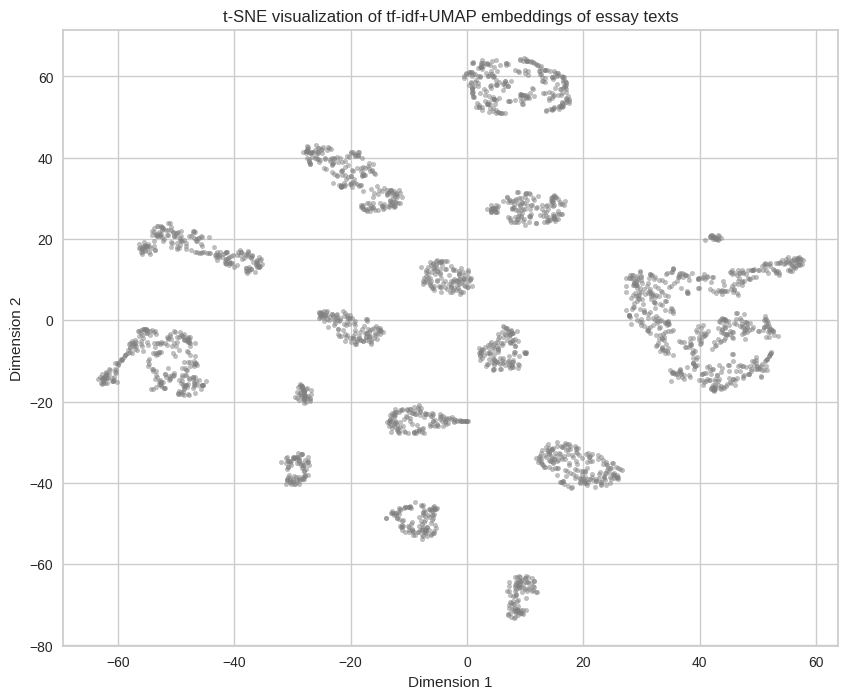

In [ ]:
df_tsne = pd.DataFrame(X_tsne, columns = ['Dim1', 'Dim2'])

plt.figure(figsize = (10, 8))
plt.scatter(df_tsne['Dim1'], df_tsne['Dim2'], c = 'grey', s = 10, alpha = 0.5)
plt.title('t-SNE visualization of tf-idf+UMAP embeddings of essay texts')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()